## Performing Frequency/Recency/CLV Analysis on UNO Sales Dataset

Importing packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Reading Pickle

In [3]:
df = pd.read_pickle('/Users/lukas/Desktop/CapstoneLukas/NOSO/Bird/sale_w_categories.pkl')

In [4]:
#column names
df.columns

Index(['STYLE#', 'COLOR', 'DESCRIPTION', 'CUST #', 'INVC DATE', 'QTY',
       'UNIT PRICE', 'EXT-AMT', 'REASON', 'IMPORT HANDMADE', 'MANUFACTORS',
       'State_sold', 'ZIP_sold', 'RELEASED YEAR', 'Seasos', 'Season target',
       'LAST RCVD', 'FIRST RCVD', 'LAST INVOICED', 'FIRST INVOICED',
       'Categories', 'Categories1', 'material_style'],
      dtype='object')

In [6]:
#shape
s = df.shape
print("This dataset has {} rows and {} columns.".format(s[0], s[1]))

This dataset has 111038 rows and 23 columns.


In [10]:
#last date
df['INVC DATE'] = pd.to_datetime(df['INVC DATE'])

In [124]:
df['INVC DATE'].sort_values(ascending=False).head(2)

70600   2018-10-03
54867   2018-10-03
Name: INVC DATE, dtype: datetime64[ns]

In [152]:
df['EXT-AMT'] = df['EXT-AMT'].str.replace('$', '')
df['EXT-AMT'] = df['EXT-AMT'].str.strip()

In [182]:
df.REASON.value_counts()

DAM      754
RETUR    698
ADJ      387
MISCH    299
REFUN    208
SHORT    148
BLIND    110
DISC      14
PROMO      7
COMM       2
short      1
Name: REASON, dtype: int64

## Data Preparation

In [7]:
from lifetimes.utils import summary_data_from_transaction_data

In [82]:
summary = summary_data_from_transaction_data(df, 'CUST #', 'INVC DATE', observation_period_end='2018-10-03', freq= 'W')

In [83]:
summary.head()

,frequency,recency,T
CUST #,,,
7HE001,9.0,83.0,142.0
AAG001,10.0,125.0,130.0
ABC002,1.0,1.0,130.0
ABI001,0.0,0.0,115.0
ACC006,0.0,0.0,135.0


## Frequency/Recency Analysis w the BG/NBD model

In [84]:
from lifetimes import BetaGeoFitter

In [85]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 409 subjects, a: 0.06, alpha: 3.38, b: 0.42, r: 0.42>


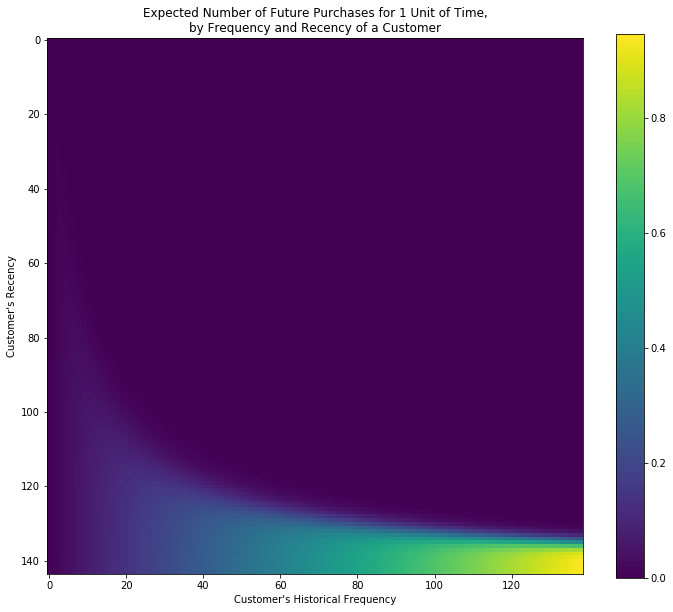

In [86]:
#plotting expected number of future purchases given frequency vs. recency
from lifetimes.plotting import plot_frequency_recency_matrix

plt.figure(figsize=(12,10))
plot_frequency_recency_matrix(bgf)

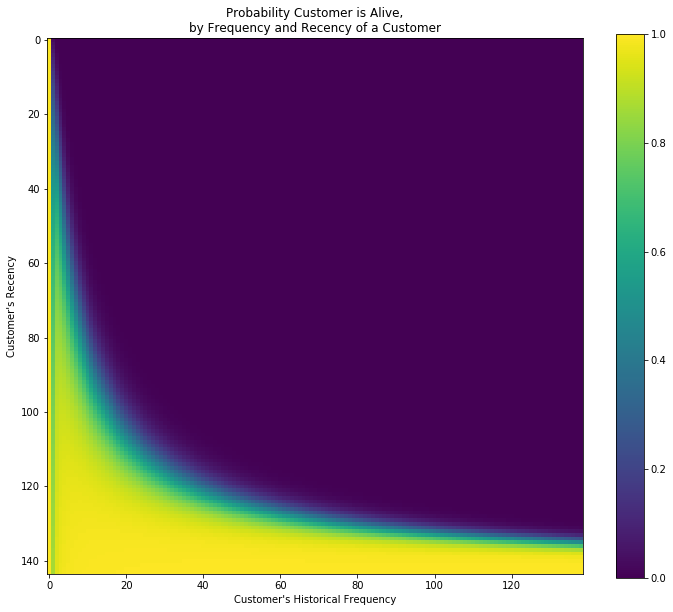

In [87]:
#plotting probability that customer is still alive given frequency vs. recency
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(12,10))
plot_probability_alive_matrix(bgf)

In [90]:
#ranking customers from best to worst given their probability of buying in the next month
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(20)

,frequency,recency,T,predicted_purchases
CUST #,,,,
HAN001,61.0,140.0,143.0,0.417885
MIB002,5.0,9.0,9.0,0.429984
ATR001,63.0,140.0,142.0,0.435034
ACC016,63.0,141.0,141.0,0.438683
SAM002,63.0,138.0,140.0,0.441087
BOS001,66.0,138.0,142.0,0.453891
AND003,77.0,141.0,143.0,0.527467
WON001,79.0,143.0,143.0,0.541974
JAN001,83.0,141.0,142.0,0.572861


## Assessing model fit

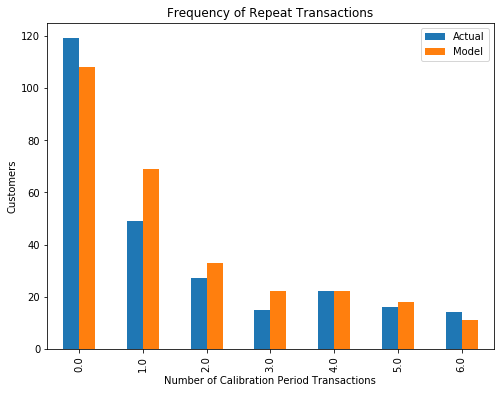

In [91]:
#comparing our data with artificially simulated data  with our fitted model’s parameters
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf, figsize=(8,6))

## Dividing into calibration and holdout data set

In [92]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'CUST #', 'INVC DATE',
                                        calibration_period_end='2018-06-30',
                                        observation_period_end='2018-10-03', 
                                                   freq='W'
                                                  )   
print(summary_cal_holdout.head())

        frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
CUST #                                                                        
7HE001            9.0         83.0  128.0                0.0                14
AAG001            6.0         78.0  116.0                4.0                14
ABC002            1.0          1.0  116.0                0.0                14
ABI001            0.0          0.0  101.0                0.0                14
ACC006            0.0          0.0  121.0                0.0                14


/anaconda3/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:202: RuntimeWarning: invalid value encountered in log
  ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))
/anaconda3/lib/python3.6/site-packages/lifetimes/fitters/beta_geo_fitter.py:206: RuntimeWarning: invalid value encountered in log
  ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + \


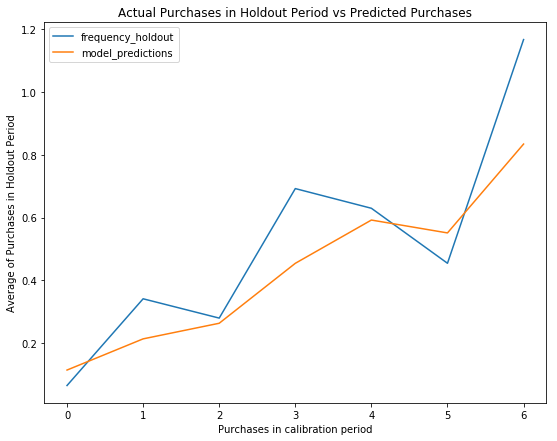

In [93]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(9,7))

## Predicting Probability of specific customer buying in X periods


In [101]:
#defining a function that returns the probability of customer x buying in n peridos
def customer_order_prob(periods=1, index=0):

    summary2 = summary
    summary2['id'] = summary2.index
    
    t = index 
    individual = summary2.iloc[periods]
    individual_id = summary2.iloc[index].id
    probability = bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
    return('The customer with ID ' + individual_id + ' will return in period ' + str(periods) + ' with a probability of {:.2f}'.format(probability))

In [107]:
#sample request
customer_order_prob(1, 10)

'The customer with ID ACE001 will return in period 1 with a probability of 0.77'

## Plot predicting probability of customer x being alive

In [114]:
def alive_plotter(id_, min_months_alive=5):   
    from lifetimes.plotting import plot_history_alive

  
    
   # months_since_birth = 5
    sp_trans = df.loc[df['CUST #'] == id_]
    plt.figure(figsize=(12,10))
    plot_history_alive(bgf, min_months_alive, sp_trans, 'INVC DATE')

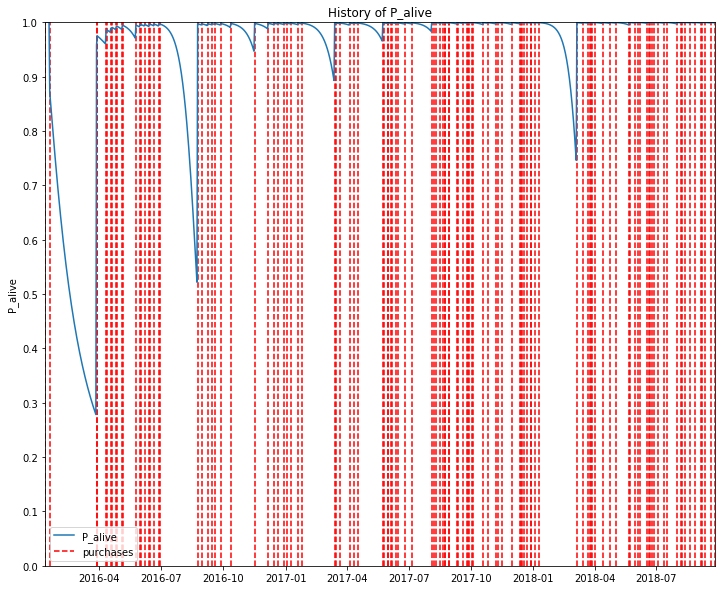

In [119]:
#address id equivalent here - put in any address/id to display graph
alive_plotter('JAN001')

## Estimating CLV using Gamma-Gamma Model

In [123]:
total = df['EXT-AMT'].str.replace('$', '')
total.str.replace('(', '-')
total.str.replace(')', '')

0           576.00 
1           576.00 
2           576.00 
3            39.00 
4            78.00 
5            39.00 
6            (39.00
7            39.00 
8            39.00 
9           780.00 
10           39.00 
11           78.00 
12           39.00 
13           (39.00
14           39.00 
15           39.00 
16           78.00 
17           39.00 
18           39.00 
19          780.00 
20           39.00 
21           39.00 
22           74.10 
23           39.00 
24           39.00 
25          156.00 
26           39.00 
27           (39.00
28           39.00 
29           39.00 
            ...    
111013        6.00 
111014       18.00 
111015       18.00 
111016       12.50 
111017        6.25 
111018        6.25 
111019        6.25 
111020       27.75 
111021        9.25 
111022        5.25 
111023       21.00 
111024        5.25 
111025       15.75 
111026       24.00 
111027        6.00 
111028        9.50 
111029        9.00 
111030       40.50 
111031       47.25 


In [ ]:
#creating a dataframe including the monetary value of each transaction
summary2 = summary_data_from_transaction_data(df, 'CUST #', 'INVC DATE',monetary_value_col='Total', observation_period_end='2018-07-16', freq= 'M')